In [1]:
import torch
import evaluate
import numpy as np
from datasets import load_dataset
from transformers import (
    pipeline,
    AutoConfig,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    GenerationConfig
)

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} as device.")

Using cuda as device.


In [3]:
model_ckpt = "google-t5/t5-small"
output_dir = "./t5-finetuned-billsum"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Loading Data

In [5]:
# loading the dataset
dataset = load_dataset("billsum")

Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 18949
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 3269
    })
    ca_test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 1237
    })
})

In [7]:
dataset["train"][0]

{'text': "SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES \n              TO NONPROFIT ORGANIZATIONS.\n\n    (a) Definitions.--In this section:\n            (1) Business entity.--The term ``business entity'' means a \n        firm, corporation, association, partnership, consortium, joint \n        venture, or other form of enterprise.\n            (2) Facility.--The term ``facility'' means any real \n        property, including any building, improvement, or appurtenance.\n            (3) Gross negligence.--The term ``gross negligence'' means \n        voluntary and conscious conduct by a person with knowledge (at \n        the time of the conduct) that the conduct is likely to be \n        harmful to the health or well-being of another person.\n            (4) Intentional misconduct.--The term ``intentional \n        misconduct'' means conduct by a person with knowledge (at the \n        time of the conduct) that the conduct is harmful to the health \n        or w

### Exploring the Data

In [8]:
# switching to pandas output format for quick exploration
dataset.set_format(type="pandas")

df = dataset["train"][:]
df.head()

,text,summary,title
0,SECTION 1. LIABILITY OF BUSINESS ENTITIES PROV...,Shields a business entity from civil liability...,A bill to limit the civil liability of busines...
1,SECTION 1. SHORT TITLE.\n\n This Act may be...,Human Rights Information Act - Requires certai...,Human Rights Information Act
2,SECTION 1. SHORT TITLE.\n\n This Act may be...,Jackie Robinson Commemorative Coin Act - Direc...,Jackie Robinson Commemorative Coin Act
3,SECTION 1. NONRECOGNITION OF GAIN WHERE ROLLOV...,Amends the Internal Revenue Code to provide (t...,To amend the Internal Revenue Code to provide ...
4,SECTION 1. SHORT TITLE.\n\n This Act may be...,Native American Energy Act - (Sec. 3) Amends t...,Native American Energy Act


In [9]:
# visualize the number of words in each column
df["text_len"] = df["text"].str.split().str.len()
df["summary_len"] = df["summary"].str.split().str.len()

<Axes: >

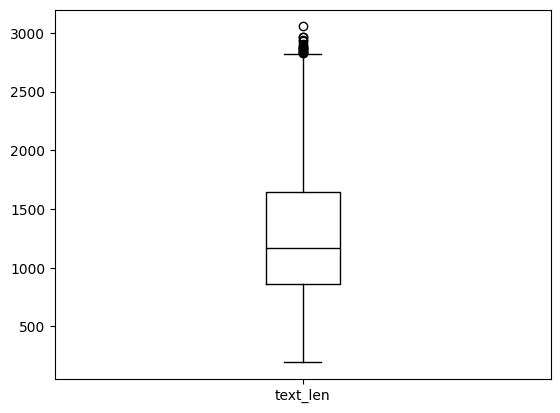

In [10]:
df.boxplot(column=["text_len"], grid=False, color="black")

<Axes: >

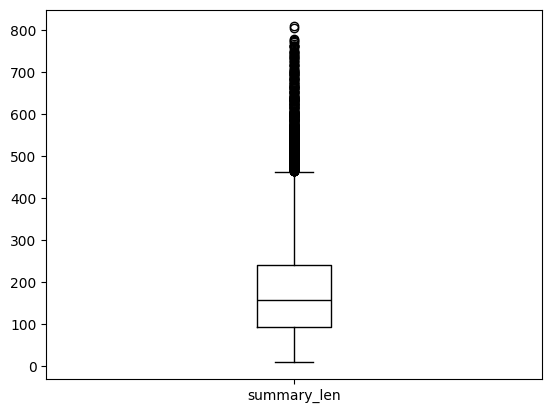

In [11]:
df.boxplot(column=["summary_len"], grid=False, color="black")

In [12]:
# max model context window is 512 tokens
tokenizer.model_max_length

512

In [13]:
dataset.reset_format()
try:
    del df
    print("deleted successfully")
except:
    pass

deleted successfully


### Preprocess

There are a few things to keep in mind as we process / tokenize the data.

1. Prefix `summarize` to each input sequence. The T5 model prefixes specific phrases to the input text, depending on the task. To get a full list of phrases, see Appendix D of the research paper: https://arxiv.org/abs/1910.10683
2. Truncate the sequences longer than the model's maximum input length.

In [14]:
prefix = "summarize: "
def preprocess(batch):

    prefixed = [prefix + seq for seq in batch["text"]]
    model_inputs = tokenizer(prefixed, truncation=True, max_length=512)
    
    labels = tokenizer(text_target=batch["summary"], truncation=True, max_length=128)
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

In [15]:
tokenized_dataset = dataset.map(preprocess, batched=True, batch_size=2000)

Map:   0%|          | 0/18949 [00:00<?, ? examples/s]

Map:   0%|          | 0/3269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1237 [00:00<?, ? examples/s]

In [16]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 18949
    })
    test: Dataset({
        features: ['text', 'summary', 'title', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3269
    })
    ca_test: Dataset({
        features: ['text', 'summary', 'title', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1237
    })
})

Inputs and outputs for any given example will vary in length. This means that both the inputs and the labels have to be padding, and we can do so using the `DataCollatorForSeq2Seq` class

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_ckpt)

### Evaluation

In [18]:
rouge = evaluate.load("rouge")

In [19]:
def compute_metrics(eval_pred):

    # batch of predictions and labels
    predictions, labels = eval_pred

    # have to use batch decode to convert a batch of token ids to strings
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id) # condition, if true, if false
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # adding a field to metric output for the length of generated text
    # only care about tokens that aren't pad tokens for every generated sequence in the batch
    prediction_len = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_len)

    return {k: round(v, 4) for k, v in result.items()}

### Training

Hugginface utilizes many (fairly reasonable) defaults in various place within the ecosystem, including text generation. Because abstractive summarization has a text generation component, we can customize the text generation for our purposes. For example, the default max length generated by a model is 20 tokens, which may not be appropriate give a use-case. Our summaries average around 150 words, for instance. Therefore, we use a configuration config that we can pass to the `TrainingArguments` class. You can find configuration details here:  https://huggingface.co/docs/transformers/main/en/main_classes/text_generation#transformers.GenerationConfig

In [20]:
generation_config = GenerationConfig(
    # params that control length of output
    max_new_tokens=100,
    early_stopping=True,
    # parameters that control generation strategy
    do_sample=True,
    num_beams=4,
    no_repeat_ngram_size=3,
    top_p=0.90,
    # special tokens
    eos_token_id=model.config.eos_token_id,
    pad_token_id=model.config.pad_token_id,
    decoder_start_token_id=model.config.decoder_start_token_id
)

In [21]:
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    learning_rate=2e-5,
    predict_with_generate=True,
    generation_config=generation_config, # helpful because predict_with_generation is True
    fp16=True,
    push_to_hub=False,
)

In [22]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.423000,2.095798,0.506800,0.301200,0.391200,0.391300,89.917100
2,2.292300,2.022802,0.514600,0.309800,0.401100,0.401000,90.245000
3,2.216900,1.994161,0.516700,0.311600,0.402700,0.402700,90.475700
4,2.209200,1.985579,0.517700,0.312800,0.403900,0.403900,90.155700


TrainOutput(global_step=4740, training_loss=2.323213575660931, metrics={'train_runtime': 5304.6435, 'train_samples_per_second': 14.289, 'train_steps_per_second': 0.894, 'total_flos': 1.0258367184371712e+16, 'train_loss': 2.323213575660931, 'epoch': 4.0})

### Inferencing

In [24]:
summarizer = pipeline("summarization", model="./t5-finetuned-billsum/checkpoint-4740")

In [27]:
def print_summary(idx):
    text = dataset["ca_test"][idx]["text"]
    actual_summary = dataset["ca_test"][idx]["summary"]
    gen_summary = summarizer(text)[0]["summary_text"]
    print(f"'>>> Review: {text}'")
    print(f"\n'>>> Actual: {actual_summary}'")
    print(f"\n'>>> Generated: {gen_summary}'")

In [28]:
print_summary(100)

'>>> Review: The people of the State of California do enact as follows:


SECTION 1.
This act shall be known and may be cited as the California Workplace Flexibility Act of
2015.
2016.
SEC. 2.
The Legislature finds and declares all of the following:
(a) California businesses and their workers suffer from outdated and inefficient workplace and overtime rules that do not allow for sufficient flexibility for employers and workers to schedule their hours of work for mutual benefit.
(b) California overtime laws, which are unique in the country, make it difficult for most employers to reach an agreement with an individual worker that would allow a flexible work schedule.
(c) Existing law does not permit a California employer to allow an individual worker to choose a flexible work schedule of four 10-hour days per week without overtime being paid.
(d) As a consequence, large, small, and micro-employers do not have the flexibility to offer their employees the opportunity to take advantage of a